# loadest-gp
LOAD ESTimator (LOADEST) is a software program for estimating some constituent using surrogate variables (covariates).
However, LOADEST has several serious limitations, and it has been all but replaced by another model known as WRTDS.
`loadest-gp` essentially reimplements WRTDS as a Gaussian process.

In [1]:
import matplotlib.pyplot as plt
import xarray as xr

from discontinuum.utils import aggregate_to_daily
from loadest_gp.providers import usgs

In [2]:
# setup

# Choptank River at Greensboro, MD
# site = "01491000"
# start_date = "1979-10-01"
# end_date = "2011-09-30"

# SF Coeur D Alene River
site = "12413470"
start_date = "1988-10-01"
end_date = "2021-09-30"

characteristic = "Inorganic nitrogen (nitrate and nitrite)"
# characteristic = 'Phosphorus'
fraction = "Dissolved"

In [3]:
# download data

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples = usgs.get_samples(
    site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction
)

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join="inner")

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/providers/usgs.py:260: UserWarning: Censored values have been removed from the dataset.
  warnings.warn(


In [4]:
%%time
# fit model

from loadest_gp import LoadestGP

model = LoadestGP()
model.fit(target=training_data["concentration"], covariates=training_data[["time", "flow"]])

MAP ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:01:25 logp = -149.56, ||grad|| = 0.20105

CPU times: user 7.35 s, sys: 1.38 s, total: 8.73 s
Wall time: 11.7 s


In [5]:
X = model.dm.X
y = model.dm.y

In [10]:
import numpy as np
import pymc as pm

n_d = X.shape[1]  # number of dimensions
dims = np.arange(n_d)
time_dim = [dims[0]]
cov_dims = dims[1:]

with pm.Model() as model:
    # seasonal trend
    eta_per = pm.HalfNormal("eta_per", sigma=1, initval=1)  # was 2
    ls_pdecay = pm.LogNormal("ls_pdecay", mu=2, sigma=1)
    # https://peterroelants.github.io/posts/gaussian-process-kernels/
    period = pm.Normal("period", mu=1, sigma=0.05)
    ls_psmooth = pm.LogNormal("ls_psmooth", mu=1, sigma=1)  # 14 sec at 0,0.5
    cov_seasonal = (
        eta_per**2
        * pm.gp.cov.Periodic(n_d, period, ls_psmooth, active_dims=time_dim)
        * pm.gp.cov.Matern52(n_d, ls_pdecay, active_dims=time_dim)
    )
    gp_seasonal = pm.gp.Latent(cov_func=cov_seasonal)

    # longterm trend
    # eta_trend =  pm.HalfNormal("eta_trend", sigma=1) # was 2
    eta_trend = pm.Exponential("eta_trend", scale=1.5)  # Exponential might to limit outliers dictating a trend
    ls_trend = pm.LogNormal("ls_trend", mu=2, sigma=1)
    cov_trend = eta_trend**2 * pm.gp.cov.ExpQuad(n_d, ls_trend, active_dims=time_dim)
    gp_trend = pm.gp.Latent(cov_func=cov_trend)

    # covariate trend
    # could include time with a different prior on ls
    eta_covariates = pm.HalfNormal("eta_covariates", sigma=2)
    ls_covariates = pm.LogNormal(
        "ls_covariates",
        mu=-1.1,
        sigma=1,
        initval=[0.5],
        shape=n_d - 1,  # exclude time
    )
    cov_covariates = eta_covariates**2 * pm.gp.cov.ExpQuad(n_d, ls=ls_covariates, active_dims=cov_dims)
    gp_covariates = pm.gp.Latent(cov_func=cov_covariates)

    # residual trend
    eta_res = pm.Exponential("eta_res", scale=0.2)
    ls_res = pm.LogNormal("ls_res", mu=-1.1, sigma=1, shape=n_d)
    cov_res = eta_res**2 * pm.gp.cov.ExpQuad(n_d, ls_res, active_dims=dims)
    gp_res = pm.gp.Latent(cov_func=cov_res)

    gp = gp_trend + gp_seasonal + gp_covariates + gp_res
    f = gp.prior("f", X=X)

    sigma = 0.1
    y_ = pm.Normal("y", mu=f, sigma=sigma, observed=y)
    y_latent = pm.Normal.dist(mu=f, sigma=sigma)
    obs = pm.Censored("obs", y_latent, lower=-100, upper=100, observed=y)

In [ ]:
with model:
    %timeit idata2 = pm.fit(n=40000) #latent 20000 -> 2,723

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:14:51 Average Loss = 2.8054e+05

In [ ]:
with model:
    %timeit mp = pm.find_MAP()

In [16]:
with model:
    idata2 = pm.fit(n=40000)  # n=10000 Loss = 6,602; #n=20000 Loss = 1,599.5 #40000 -> 322.1

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01 Average Loss = 322.06

Finished [100%]: Average Loss = 321.97


In [17]:
with model:
    s = idata2.sample(1000)

In [23]:
s.posterior.ls_res.mean(axis=1)

<xarray.DataArray 'ls_res' (chain: 1, ls_res_dim_0: 2)> Size: 16B
array([[0.11953469, 0.59439335]])
Coordinates:
  * chain         (chain) int64 8B 0
  * ls_res_dim_0  (ls_res_dim_0) int64 16B 0 1

Text(0.5, 0, 'Year')

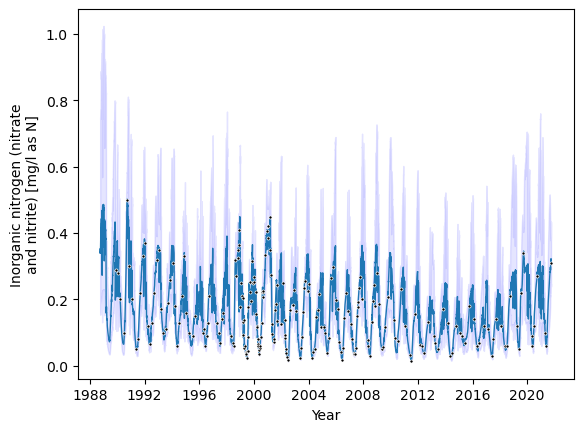

In [118]:
# plot result
fig, ax = plt.subplots()
model.plot(daily[["time", "flow"]], ax=ax)
ax.set_xlabel("Year")

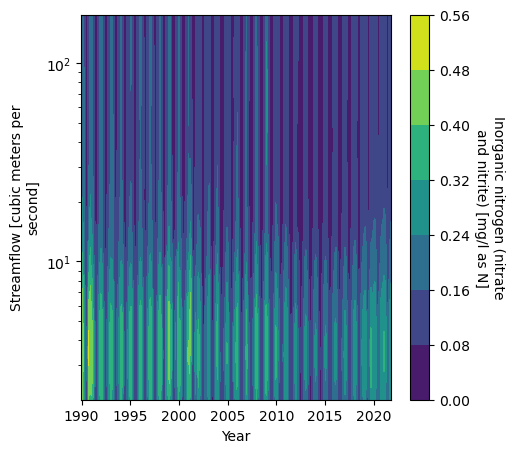

In [111]:
#  plot
model.contourf(levels=5)
plt.show()

In [112]:
# simulate concentration
sim_slice = daily[["time", "flow"]].sel(time=slice("1990", "2020"))

sim = model.sample(sim_slice)

In [113]:
# simulate flux
def to_flux(concentration, flow):
    flux = concentration * flow * 86400 * 1e-6
    flux.attrs = sim.attrs
    flux.attrs["units"] = "kilograms per day"
    flux.attrs["standard_name"] = "flux"
    return flux

In [114]:
import matplotlib.pyplot as plt


def plot_annual_sum(sim):
    """Describe"""
    fig, ax = plt.subplots()
    annual = sim.resample(time="YE").sum()
    annual.attrs["units"] = "kilograms per year"
    annual.attrs["short_name"] = "flux"

    annual.to_dataframe(name=annual.attrs["short_name"]).boxplot(by="time", showfliers=False, grid=False, ax=ax)
    ax.set_ylabel("{}\n[{}]".format(annual.attrs["long_name"], annual.attrs["units"]))
    ax.set_xlabel("Year")
    ax.tick_params(axis="x", labelrotation=90)

    labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual.time.dt.year.values)]
    ax.set_xticklabels(labels)
    ax.set_title("")
    # fig.suptitle('')
    return ax

In [ ]:
flux = to_flux(sim, sim_slice["flow"])
plot_annual_sum(flux)

In [ ]:
# now let's create the pseudo-counterfactual
from discontinuum.utils import time_substitution

counterfactual = time_substitution(sim_slice, interval=slice("2005", "2005"))

In [ ]:
counterfactual_sim = model.sample(counterfactual)
counterfactual_flux = to_flux(counterfactual_sim, sim_slice["flow"])

In [ ]:
plot_annual_sum(counterfactual_sim)